### 

Neural Net for prediciting 5 seconds into an object's future trajectory

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plots
from skimage import io, transform
# from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms, utils
from typing import List, Dict, Tuple
from tqdm import tqdm

### Dataset Class

In [2]:
class SimDataset(Dataset):
    '''
    Extract dataset from csv file
    '''
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path, header=0, skiprows=50).values.astype(np.float32)

        # skipping the first and last 50 time steps
        self.valid_indices = list(range(0, len(self.data)-50)) 

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        row_idx = self.valid_indices[idx]
        row = self.data[row_idx]
        future_row = self.data[row_idx + 50]

        # Extract components
        past_positions = row[1:151].reshape(50, 3)           # [50, 3]
        velocity = row[151:154]                              # [3]
        acceleration = row[154:157]                          # [3]
        future_positions = future_row[1:151].reshape(50, 3)       # [50, 3]

        # Convert to tensors
        return {
            'past_positions': torch.tensor(past_positions),      # [50, 3]
            'velocity': torch.tensor(velocity),                  # [3]
            'acceleration': torch.tensor(acceleration),          # [3]
            'future_positions': torch.tensor(future_positions)   # [50, 3]
        }

  


### Model Architecture

Claude

In [3]:

import torch.optim as optim
import time

class TrajectoryPredictor(nn.Module):
    """LSTM-based trajectory prediction model optimized for Orin"""
    
    def __init__(self, 
                 hidden_size: int = 128,
                 num_layers: int = 2,
                 dropout: float = 0.1):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Input processing layers
        self.position_embedding = nn.Linear(3, 32)
        self.velocity_embedding = nn.Linear(3, 16)
        self.acceleration_embedding = nn.Linear(3, 16)
        
        # LSTM encoder for processing past trajectory
        # Input: position embeddings (32) + velocity (16) + acceleration (16) = 64
        self.lstm_encoder = nn.LSTM(
            input_size=64,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # LSTM decoder for generating future trajectory
        self.lstm_decoder = nn.LSTM(
            input_size=3,  # Just position coordinates
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output projection layer
        self.output_projection = nn.Linear(hidden_size, 3)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Layer normalization for stability
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, past_positions: torch.Tensor, velocity: torch.Tensor, 
                acceleration: torch.Tensor) -> torch.Tensor:
        """
        Args:
            past_positions: [batch_size, 50, 3] - Past 5 seconds of positions
            velocity: [batch_size, 3] - Current velocity
            acceleration: [batch_size, 3] - Current acceleration
        
        Returns:
            predictions: [batch_size, 50, 3] - Future 5 seconds of positions
        """
        batch_size, seq_len, _ = past_positions.shape
        
        # Embed position features
        pos_embedded = self.position_embedding(past_positions)  # [batch_size, 50, 32]
        
        # Expand velocity and acceleration to match sequence length
        vel_expanded = velocity.unsqueeze(1).expand(-1, seq_len, -1)  # [batch_size, 50, 3]
        acc_expanded = acceleration.unsqueeze(1).expand(-1, seq_len, -1)  # [batch_size, 50, 3]
        
        # Embed velocity and acceleration
        vel_embedded = self.velocity_embedding(vel_expanded)  # [batch_size, 50, 16]
        acc_embedded = self.acceleration_embedding(acc_expanded)  # [batch_size, 50, 16]
        
        # Concatenate all features
        encoder_input = torch.cat([pos_embedded, vel_embedded, acc_embedded], dim=2)  # [batch_size, 50, 64]
        
        # Encode past trajectory
        encoder_output, (hidden, cell) = self.lstm_encoder(encoder_input)
        
        # Apply layer normalization to hidden states
        hidden = self.layer_norm(hidden)
        
        # Initialize decoder input with last known position
        decoder_input = past_positions[:, -1:, :]  # [batch_size, 1, 3]
        
        predictions = []
        
        # Generate future trajectory step by step
        for _ in range(50):  # Predict 50 future timesteps
            decoder_output, (hidden, cell) = self.lstm_decoder(decoder_input, (hidden, cell))
            
            # Project to output space
            output = self.output_projection(self.dropout(decoder_output))
            predictions.append(output)
            
            # Use current prediction as next input
            decoder_input = output
        
        # Concatenate all predictions
        predictions = torch.cat(predictions, dim=1)  # [batch_size, 50, 3]
        
        return predictions

class TrajectoryPredictionSystem:
    """Complete system for trajectory prediction"""
    
    def __init__(self, model_path: str = None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = TrajectoryPredictor().to(self.device)
        
        if model_path:
            self.load_model(model_path)
    
    def train(self, train_csv_path: str, val_csv_path: str = None, 
              epochs: int = 100, batch_size: int = 32, learning_rate: float = 0.001):
        """Train the model using SimDataset"""
        
        # Create datasets
        train_dataset = SimDataset(train_csv_path)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        
        val_loader = None
        if val_csv_path:
            val_dataset = SimDataset(val_csv_path)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)
        
        best_val_loss = float('inf')
        
        print(f"Training on {self.device}")
        print(f"Dataset size: {len(train_dataset)}")
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            num_batches = 0
            
            for batch_idx, batch in enumerate(train_loader):
                # Move data to device
                past_positions = batch['past_positions'].to(self.device)
                velocity = batch['velocity'].to(self.device)
                acceleration = batch['acceleration'].to(self.device)
                future_positions = batch['future_positions'].to(self.device)
                
                optimizer.zero_grad()
                
                # Forward pass
                predictions = self.model(past_positions, velocity, acceleration)
                loss = criterion(predictions, future_positions)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                train_loss += loss.item()
                num_batches += 1
                
                # Print progress
                if batch_idx % 100 == 0:
                    print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                          f'Loss: {loss.item():.6f}')
            
            train_loss /= num_batches
            
            # Validation phase
            val_loss = None
            if val_loader:
                self.model.eval()
                val_loss = 0.0
                val_batches = 0
                
                with torch.no_grad():
                    for batch in val_loader:
                        past_positions = batch['past_positions'].to(self.device)
                        velocity = batch['velocity'].to(self.device)
                        acceleration = batch['acceleration'].to(self.device)
                        future_positions = batch['future_positions'].to(self.device)
                        
                        predictions = self.model(past_positions, velocity, acceleration)
                        val_loss += criterion(predictions, future_positions).item()
                        val_batches += 1
                
                val_loss /= val_batches
                scheduler.step(val_loss)
                
                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    self.save_model('best_model.pth')
                    print(f'New best model saved with validation loss: {val_loss:.6f}')
                
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
            else:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}')
            
            # Save checkpoint every 10 epochs
            if (epoch + 1) % 10 == 0:
                self.save_model(f'checkpoint_epoch_{epoch+1}.pth')
    
    def predict(self, past_positions: np.ndarray, velocity: np.ndarray, 
                acceleration: np.ndarray) -> np.ndarray:
        """
        Predict future trajectory
        
        Args:
            past_positions: Array of shape [50, 3] containing past 5 seconds of positions
            velocity: Array of shape [3] containing current velocity
            acceleration: Array of shape [3] containing current acceleration
            
        Returns:
            future_positions: Array of shape [50, 3] containing predicted future positions
        """
        self.model.eval()
        
        with torch.no_grad():
            # Convert to tensors and add batch dimension
            past_positions_tensor = torch.FloatTensor(past_positions).unsqueeze(0).to(self.device)
            velocity_tensor = torch.FloatTensor(velocity).unsqueeze(0).to(self.device)
            acceleration_tensor = torch.FloatTensor(acceleration).unsqueeze(0).to(self.device)
            
            # Apply half precision if model is in half precision
            if next(self.model.parameters()).dtype == torch.float16:
                past_positions_tensor = past_positions_tensor.half()
                velocity_tensor = velocity_tensor.half()
                acceleration_tensor = acceleration_tensor.half()
            
            # Predict
            predictions = self.model(past_positions_tensor, velocity_tensor, acceleration_tensor)
            
            # Convert back to numpy
            future_positions = predictions.squeeze(0).cpu().numpy()
            
        return future_positions
    
    def evaluate(self, test_csv_path: str, batch_size: int = 32) -> Dict[str, float]:
        """Evaluate model performance on test set"""
        test_dataset = SimDataset(test_csv_path)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        self.model.eval()
        total_mse = 0.0
        total_mae = 0.0
        num_samples = 0
        
        with torch.no_grad():
            for batch in test_loader:
                past_positions = batch['past_positions'].to(self.device)
                velocity = batch['velocity'].to(self.device)
                acceleration = batch['acceleration'].to(self.device)
                future_positions = batch['future_positions'].to(self.device)
                
                predictions = self.model(past_positions, velocity, acceleration)
                
                # Calculate metrics
                mse = F.mse_loss(predictions, future_positions, reduction='sum')
                mae = F.l1_loss(predictions, future_positions, reduction='sum')
                
                total_mse += mse.item()
                total_mae += mae.item()
                num_samples += predictions.numel()
        
        avg_mse = total_mse / num_samples
        avg_mae = total_mae / num_samples
        rmse = np.sqrt(avg_mse)
        
        metrics = {
            'MSE': avg_mse,
            'MAE': avg_mae,
            'RMSE': rmse
        }
        
        print(f"Test Results:")
        print(f"MSE: {avg_mse:.6f}")
        print(f"MAE: {avg_mae:.6f}")
        print(f"RMSE: {rmse:.6f}")
        
        return metrics
    
    def save_model(self, path: str):
        """Save the trained model"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'model_config': {
                'hidden_size': 128,
                'num_layers': 2,
                'dropout': 0.1
            }
        }, path)
    
    def load_model(self, path: str):
        """Load a pre-trained model"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        print(f"Model loaded from {path}")
    
    def optimize_for_inference(self):
        """Optimize model for inference on Orin"""
        self.model.eval()
        
        # Create dummy inputs for optimization
        dummy_past_positions = torch.randn(1, 50, 3).to(self.device)
        dummy_velocity = torch.randn(1, 3).to(self.device)
        dummy_acceleration = torch.randn(1, 3).to(self.device)
        
        # Enable TensorRT optimization if available
        if hasattr(torch, 'jit'):
            try:
                self.model = torch.jit.trace(
                    self.model, 
                    (dummy_past_positions, dummy_velocity, dummy_acceleration)
                )
                print("Model traced for TensorRT optimization")
            except Exception as e:
                print(f"TensorRT tracing failed: {e}")
        
        # Enable half precision for faster inference on Orin
        if self.device.type == 'cuda':
            self.model = self.model.half()
            print("Model converted to half precision")
    
    def benchmark_inference(self, num_iterations: int = 1000):
        """Benchmark inference speed"""
        self.model.eval()
        
        # Create dummy inputs
        dummy_past_positions = torch.randn(1, 50, 3).to(self.device)
        dummy_velocity = torch.randn(1, 3).to(self.device)
        dummy_acceleration = torch.randn(1, 3).to(self.device)
        
        # Apply half precision if model is in half precision
        if next(self.model.parameters()).dtype == torch.float16:
            dummy_past_positions = dummy_past_positions.half()
            dummy_velocity = dummy_velocity.half()
            dummy_acceleration = dummy_acceleration.half()
        
        # Warmup
        for _ in range(10):
            with torch.no_grad():
                _ = self.model(dummy_past_positions, dummy_velocity, dummy_acceleration)
        
        # Synchronize CUDA if available
        if self.device.type == 'cuda':
            torch.cuda.synchronize()
        
        # Benchmark
        start_time = time.time()
        for _ in range(num_iterations):
            with torch.no_grad():
                _ = self.model(dummy_past_positions, dummy_velocity, dummy_acceleration)
        
        if self.device.type == 'cuda':
            torch.cuda.synchronize()
        
        end_time = time.time()
        avg_time = (end_time - start_time) / num_iterations
        
        print(f"Average inference time: {avg_time*1000:.2f} ms")
        print(f"Inference frequency: {1/avg_time:.1f} Hz")
        print(f"Real-time capability: {'Yes' if avg_time < 0.1 else 'No'} (10Hz requirement)")

Chat

In [5]:
# class Chomp1d(nn.Module):
#     """Trims padding on the right to maintain output length = input length"""
#     def __init__(self, chomp_size):
#         super().__init__()
#         self.chomp_size = chomp_size

#     def forward(self, x):
#         return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

# class TemporalBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation),
#             Chomp1d(padding),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, dilation),
#             Chomp1d(padding),
#             nn.ReLU(),
#             nn.Dropout(dropout)
#         )
#         self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         out = self.net(x)
#         res = x if self.downsample is None else self.downsample(x)
#         return self.relu(out + res)

# class TCN(nn.Module):
#     def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
#         super().__init__()
#         layers = []
#         for i in range(len(num_channels)):
#             dilation = 2 ** i
#             in_ch = num_inputs if i == 0 else num_channels[i-1]
#             out_ch = num_channels[i]
#             layers += [TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
#                                      dilation=dilation, padding=(kernel_size-1)*dilation, dropout=dropout)]
#         self.network = nn.Sequential(*layers)

#     def forward(self, x):  # x: [B, C=3, T=50]
#         return self.network(x)

# class TrajectoryTCNModel(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # TCN encoder for past positions
#         self.tcn = TCN(num_inputs=3, num_channels=[64, 64, 64], kernel_size=3, dropout=0.1)

#         # Velocity + Acceleration encoder
#         self.state_encoder = nn.Sequential(
#             nn.Linear(6, 64),
#             nn.ReLU(),
#             nn.Linear(64, 64)
#         )

#         # Final projection to 50×3 output
#         self.decoder = nn.Sequential(
#             nn.Linear(64 + 64, 128),
#             nn.ReLU(),
#             nn.Linear(128, 150),  # 50 x 3
#         )

#     def forward(self, past_positions, velocity, acceleration):
#         """
#         Inputs:
#             past_positions: [B, 50, 3]
#             velocity: [B, 3]
#             acceleration: [B, 3]
#         Output:
#             predicted_future: [B, 50, 3]
#         """
#         x = past_positions.permute(0, 2, 1)  # [B, 3, 50]
#         x_tcn = self.tcn(x)                  # [B, 64, 50]
#         x_tcn = x_tcn.mean(dim=2)            # [B, 64] (temporal pooling)

#         v_a = torch.cat([velocity, acceleration], dim=1)  # [B, 6]
#         x_state = self.state_encoder(v_a)                 # [B, 64]

#         fused = torch.cat([x_tcn, x_state], dim=1)        # [B, 128]
#         out = self.decoder(fused)                         # [B, 150]
#         return out.view(-1, 50, 3)                        # [B, 50, 3]


### Training Loop

In [6]:
#  # Initialize the system
#     system = TrajectoryPredictionSystem()
    
#     # Training
#     print("Starting training...")
#     system.train(
#         train_csv_path='train_data.csv',
#         val_csv_path='val_data.csv',
#         epochs=100,
#         batch_size=64,
#         learning_rate=0.001
#     )
    
#     # Load best model
#     system.load_model('best_model.pth')
    
#     # Evaluate on test set
#     print("\nEvaluating on test set...")
#     metrics = system.evaluate('test_data.csv')
    
#     # Optimize for inference
#     print("\nOptimizing for Orin inference...")
#     system.optimize_for_inference()
    
#     # Benchmark performance
#     print("\nBenchmarking inference speed...")
#     system.benchmark_inference()
    
#     # Example single prediction
#     print("\nExample prediction:")
#     past_positions = np.random.randn(50, 3)
#     velocity = np.array([1.0, 0.5, 0.1])
#     acceleration = np.array([0.1, 0.0, -0.05])
    
#     future_trajectory = system.predict(past_positions, velocity, acceleration)
#     print(f"Predicted future trajectory shape: {future_trajectory.shape}")

Load data

In [4]:
epochs = 100
batch_size = 32
learning_rate = 0.001
val_ratio = 0.2
num_workers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrajectoryPredictor()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        

csv_paths = ['trajectory_data/boomerang_back_forth.csv', 
             'trajectory_data/bounce.csv', 
             'trajectory_data/circle075.csv',
             'trajectory_data/figure8r34.csv',
             'trajectory_data/figure8r075.csv',
             'trajectory_data/I.csv',
             'trajectory_data/line_back_forth.csv',
             'trajectory_data/M.csv',
             'trajectory_data/reciprocating.csv',
             'trajectory_data/rectangle.csv',
             'trajectory_data/square.csv',
             'trajectory_data/T.csv',
             'trajectory_data/trefoil_twice.csv'
             ]


datasets = [SimDataset(csv) for csv in csv_paths]
combined_dataset = ConcatDataset(datasets)
val_size = int(len(combined_dataset) * val_ratio)
train_size = len(combined_dataset) - val_size

train_dataset = torch.utils.data.Subset(combined_dataset, list(range(train_size)))
val_dataset = torch.utils.data.Subset(combined_dataset, list(range(train_size, len(combined_dataset))))

# Full data loader
# dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

best_val_loss = float('inf')

print(f"Training on {device}")
print(f"Dataset size: {len(train_dataset)}")


Training on cuda
Dataset size: 21970


Training loop

In [8]:
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    num_batches = 0
    
    for batch_idx, batch in enumerate(train_loader):
        # Move data to device
        past_positions = batch['past_positions'].to(device)
        velocity = batch['velocity'].to(device)
        acceleration = batch['acceleration'].to(device)
        future_positions = batch['future_positions'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(past_positions, velocity, acceleration)
        loss = criterion(predictions, future_positions)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        num_batches += 1
        
        # Print progress
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                    f'Loss: {loss.item():.6f}')
    
    train_loss /= num_batches
    
    # Validation phase
    val_loss = None
    if val_loader:
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                past_positions = batch['past_positions'].to(device)
                velocity = batch['velocity'].to(device)
                acceleration = batch['acceleration'].to(device)
                future_positions = batch['future_positions'].to(device)
                
                predictions = model(past_positions, velocity, acceleration)
                val_loss += criterion(predictions, future_positions).item()
                val_batches += 1
        
        val_loss /= val_batches
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # self.save_model('best_model.pth')
            print(f'New best model saved with validation loss: {val_loss:.6f}')
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    else:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}')
    
    # Save checkpoint every 10 epochs
    # if (epoch + 1) % 10 == 0:
    #     self.save_model(f'checkpoint_epoch_{epoch+1}.pth')

Epoch 1/100, Batch 0/687, Loss: 1.691813
Epoch 1/100, Batch 100/687, Loss: 0.512017


KeyboardInterrupt: 

Training loop old

In [ ]:
# csv_paths = ['trajectory_data/boomerang_back_forth.csv', 
#              'trajectory_data/bounce.csv', 
#              'trajectory_data/circle075.csv',
#              'trajectory_data/figure8r34.csv',
#              'trajectory_data/figure8r075.csv',
#              'trajectory_data/I.csv',
#              'trajectory_data/line_back_forth.csv',
#              'trajectory_data/M.csv',
#              'trajectory_data/reciprocating.csv',
#              'trajectory_data/rectangle.csv',
#              'trajectory_data/square.csv',
#              'trajectory_data/T.csv',
#              'trajectory_data/trefoil_twice.csv'
#              ]

# datasets = [SimDataset(csv) for csv in csv_paths]
# combined_dataset = ConcatDataset(datasets)

# dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Instantiate model
# model = TrajectoryTCNModel().to(device)

# # Loss and optimizer
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# num_epochs = 100

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0

#     for batch in dataloader:
#         past_positions = batch['past_positions'].to(device)    # [B, 50, 3]
#         velocity = batch['velocity'].to(device)                # [B, 3]
#         acceleration = batch['acceleration'].to(device)        # [B, 3]
#         target = batch['future_positions'].to(device)           # [B, 50, 3]

#         optimizer.zero_grad()
#         outputs = model(past_positions, velocity, acceleration)  # [B, 50, 3]

#         loss = criterion(outputs, target)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * past_positions.size(0)

#     avg_loss = total_loss / len(combined_dataset)
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")



### Save whole model

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'model_config': {
                'hidden_size': 128,
                'num_layers': 2,
                'dropout': 0.1
            }
        }, 'mod1.pth')

### Load the model

In [6]:
checkpoint = torch.load('mod1.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Evaluation

3D plot

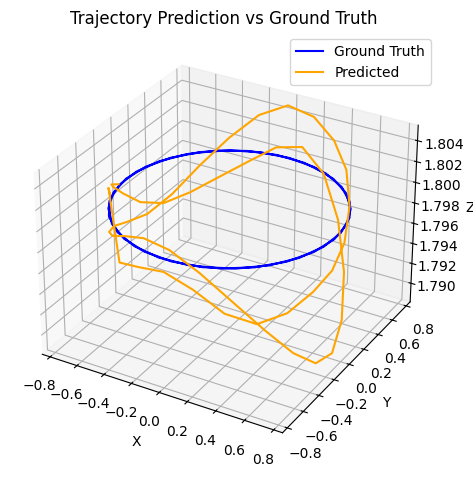

In [11]:
# Put model in eval mode and no gradients needed
model.eval()
with torch.no_grad():
    sample = combined_dataset[5000]  # pick an index from your dataset

    # Prepare inputs (add batch dim)
    past = sample['past_positions'].unsqueeze(0).to(device)     # [1, 50, 3]
    velocity = sample['velocity'].unsqueeze(0).to(device)        # [1, 3]
    acceleration = sample['acceleration'].unsqueeze(0).to(device)  # [1, 3]

    # Run model
    predicted = model(past, velocity, acceleration)[0].cpu().numpy()   # [50, 3]
    ground_truth = sample['future_positions'].numpy()                  # [50, 3]

# Plot both predicted and ground truth trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2], label='Ground Truth', color='blue')
ax.plot(predicted[:, 0], predicted[:, 1], predicted[:, 2], label='Predicted', color='orange')

ax.set_title("Trajectory Prediction vs Ground Truth")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()


2D plot

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0

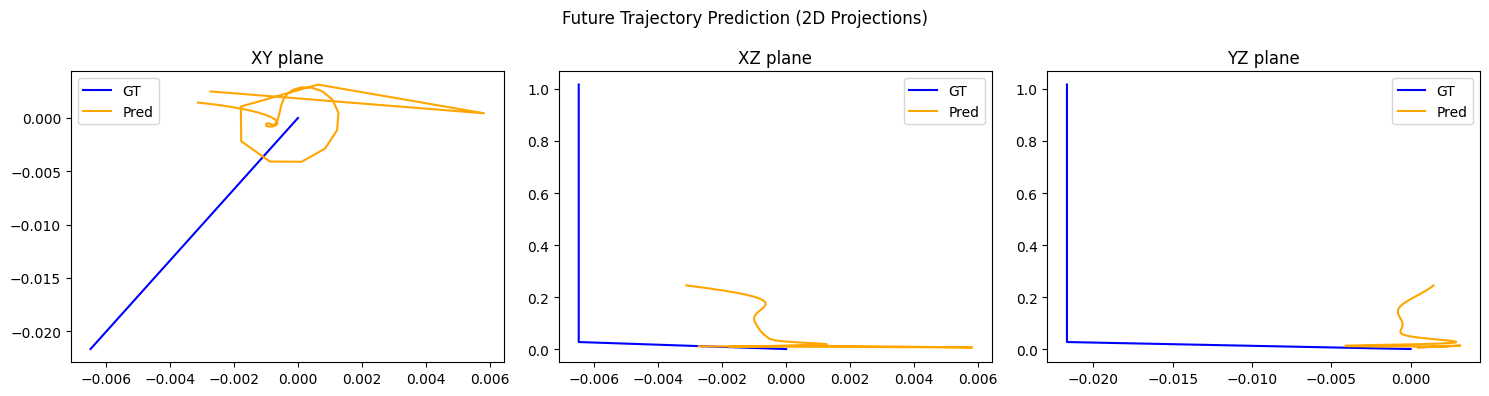

In [ ]:
# Set model to eval mode
model.eval()
with torch.no_grad():
    sample = combined_dataset[100]  # pick a sample index
    past = sample['past_positions'].unsqueeze(0).to(device)       # [1, 50, 3]
    velocity = sample['velocity'].unsqueeze(0).to(device)         # [1, 3]
    acceleration = sample['acceleration'].unsqueeze(0).to(device) # [1, 3]

    pred = model(past, velocity, acceleration)[0].cpu().numpy()   # [50, 3]
    gt = sample['future_positions'].numpy()                       # [50, 3]

# Plot 2D projections
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(gt[:, 0], gt[:, 1], label='GT', color='blue')
axs[0].plot(pred[:, 0], pred[:, 1], label='Pred', color='orange')
axs[0].set_title("XY plane")
axs[0].legend()

axs[1].plot(gt[:, 0], gt[:, 2], label='GT', color='blue')
axs[1].plot(pred[:, 0], pred[:, 2], label='Pred', color='orange')
axs[1].set_title("XZ plane")
axs[1].legend()

axs[2].plot(gt[:, 1], gt[:, 2], label='GT', color='blue')
axs[2].plot(pred[:, 1], pred[:, 2], label='Pred', color='orange')
axs[2].set_title("YZ plane")
axs[2].legend()

plt.suptitle("Future Trajectory Prediction (2D Projections)")
plt.tight_layout()
plt.show()
